In [1]:
# Install PyTorch
!pip install -U torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html


In [2]:
!rm -rf tcc
!git clone https://github.com/matheussn/tcc.git
%cd tcc

In [3]:
!rm -rf mmsegmentation
!git clone -b v0.20.2 https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 5894, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (284/284), done.
remote: Total 5894 (delta 193), reused 200 (delta 111), pack-reused 5494
Receiving objects: 100% (5894/5894), 12.52 MiB | 10.59 MiB/s, done.
Resolving deltas: 100% (4262/4262), done.
Note: switching to '991b0512b9f4835275957e4c4896b5f4c4696eac'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

/home/neto/projects/tcc/mmsegmentation
Obtaining file:///home/ne

In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.datasets import build_dataset
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed, train_segmentor
from mmseg.models import build_segmentor
print(mmseg.__version__)

import mmcv
from mmcv import Config

import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

1.8.1+cu101 True
0.20.2


In [5]:
!rm -rf segmentation/
!unzip ../../segmentation.zip

Archive:  ../segmentation.zip
   creating: segmentation/
   creating: segmentation/annotations/
  inflating: segmentation/annotations/image020-roi1.tif  
  inflating: segmentation/annotations/image008-roi1.tif  
  inflating: segmentation/annotations/image032-roi1.tif  
  inflating: segmentation/annotations/image019-roi2.tif  
  inflating: segmentation/annotations/image019-roi5.tif  
  inflating: segmentation/annotations/image058-roi5.tif  
  inflating: segmentation/annotations/image038-roi4.tif  
  inflating: segmentation/annotations/image058-roi1.tif  
  inflating: segmentation/annotations/image021-roi3.tif  
  inflating: segmentation/annotations/image006-roi2.tif  
  inflating: segmentation/annotations/image021-roi6.tif  
  inflating: segmentation/annotations/image038-roi1.tif  
  inflating: segmentation/annotations/image003-2-roi3.tif  
  inflating: segmentation/annotations/image038-roi3.tif  
  inflating: segmentation/annotations/image039-roi3.tif  
  inflating: segmentation/annota

In [6]:
data_root = 'segmentation'
img_dir = 'images'
ann_dir = 'annotations'

In [7]:
classes = ('bg', 'cell')
palette = [[0, 0, 0], [255, 255, 255]]

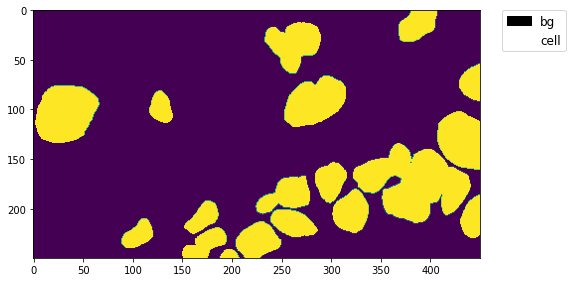

In [8]:
# Let's take a look at the segmentation map we got

img = Image.open('segmentation/annotations/image003-2-roi1.tif')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [9]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.tif')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [10]:
@DATASETS.register_module()
class DysplasiaDataSet(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.jpg', seg_map_suffix='.tif', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [16]:
cfg = Config.fromfile('../models/pspnet.py')

In [17]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

In [18]:
datasets = [build_dataset(cfg.data.train)]

2022-01-27 20:33:38,369 - mmseg - INFO - Loaded 96 images


In [19]:
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [ ]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

In [ ]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('/content/mmsegmentation/segmentation/images/image003-2-roi1.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

In [ ]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image003-2-roi1.jpg')
result = mmcv.imread('segmentation/annotations/image003-2-roi1.tif',flag='grayscale')

model.cfg = cfg
# result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

In [ ]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('/content/mmsegmentation/segmentation/images/image037-roi4.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

In [ ]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('/content/mmsegmentation/segmentation/images/image037-roi4.jpg')
result = mmcv.imread('/content/mmsegmentation/segmentation/annotations/image037-roi4.tif',flag='grayscale')

model.cfg = cfg
# result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)